# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "output_sample"

In [ ]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/MLPS Case Study/data/clean_data.pickle'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open(path, "rb" ) )

In [ ]:
data.head()

,grade,verification_status,emp_length,term,purpose,home_ownership,loan_amnt,funded_amnt,annual_inc,delinq_2yrs,...,issue_d,earliest_cr_line,last_pymnt_d,loan_status,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb
0,B,Verified,10+ years,36 months,credit_card,RENT,5000.0,5000.0,24000.0,0.0,...,2011-12-01,1985-01-01,2015-01-01,Fully Paid,37.027454,36,0.057544,0.055947,0.413340,1.075884
1,C,Source Verified,< 1 year,60 months,car,RENT,2500.0,2500.0,30000.0,0.0,...,2011-12-01,1999-04-01,2013-04-01,Charged Off,16.000329,60,-0.118838,-0.118838,0.058081,0.401688
2,C,Not Verified,10+ years,36 months,small_business,RENT,2400.0,2400.0,12252.0,0.0,...,2011-12-01,2001-11-01,2014-06-01,Fully Paid,29.996509,36,0.084120,0.100956,0.502458,1.318829
3,C,Source Verified,10+ years,36 months,other,RENT,10000.0,10000.0,49200.0,0.0,...,2011-12-01,1996-02-01,2015-01-01,Fully Paid,37.027454,36,0.074396,0.072332,0.439784,1.130894
4,B,Source Verified,1 year,60 months,other,RENT,3000.0,3000.0,80000.0,0.0,...,2011-12-01,1996-01-01,2017-01-01,Fully Paid,61.044375,60,0.071127,0.069910,0.367104,0.861487


In [ ]:
# drop the NaN values for return in order to calculate investment strategies
data.dropna(subset=['ret_PESS','ret_OPT','ret_INTa', 'ret_INTb'],inplace=True)

In [ ]:
data.columns

Index(['grade', 'verification_status', 'emp_length', 'term', 'purpose',
       'home_ownership', 'loan_amnt', 'funded_amnt', 'annual_inc',
       'delinq_2yrs', 'dti', 'fico_range_high', 'fico_range_low', 'open_acc',
       'pub_rec', 'revol_bal', 'total_pymnt', 'recoveries', 'int_rate',
       'revol_util', 'issue_d', 'earliest_cr_line', 'last_pymnt_d',
       'loan_status', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT',
       'ret_INTa', 'ret_INTb'],
      dtype='object')

In [ ]:
discrete_features

['grade',
 'verification_status',
 'emp_length',
 'term',
 'purpose',
 'home_ownership']

In [ ]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'annual_inc',
 'delinq_2yrs',
 'dti',
 'fico_range_high',
 'fico_range_low',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'int_rate',
 'revol_util']

In [ ]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where((data['loan_status'] == 'Charged Off') | (data['loan_status'] == 'Default'), True, False)

In [ ]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [ ]:
# get an overview of data 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958736 entries, 0 to 2777771
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   grade                958736 non-null  object        
 1   verification_status  958736 non-null  object        
 2   emp_length           895351 non-null  object        
 3   term                 958736 non-null  object        
 4   purpose              958736 non-null  object        
 5   home_ownership       958736 non-null  object        
 6   loan_amnt            958736 non-null  float64       
 7   funded_amnt          958736 non-null  float64       
 8   annual_inc           958736 non-null  float64       
 9   delinq_2yrs          958736 non-null  float64       
 10  dti                  958736 non-null  float64       
 11  fico_range_high      958736 non-null  float64       
 12  fico_range_low       958736 non-null  float64       
 13  open_acc     

In [ ]:
## define your set of features to use in different models
your_features = ['grade', 'verification_status', 'emp_length', 'term', 'purpose', 'home_ownership',
                 'loan_amnt', 'funded_amnt', 'annual_inc', 'delinq_2yrs', 'dti',
                 'fico_range_high', 'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal', 'total_pymnt',
                 'recoveries', 'int_rate', 'revol_util', 'loan_status', 'loan_length', 'term_num',
                 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'cr_hist','issue_d','last_payment_d']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Naive Bayes Classifier
Fit time: 0.1 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8008
              precision    recall  f1-score   support

  No default     0.8008    1.0000    0.8894     16016
     Default     0.0000    0.0000    0.0000      3984

    accuracy                         0.8008     20000
   macro avg     0.4004    0.5000    0.4447     20000
weighted avg     0.6413    0.8008    0.7122     20000



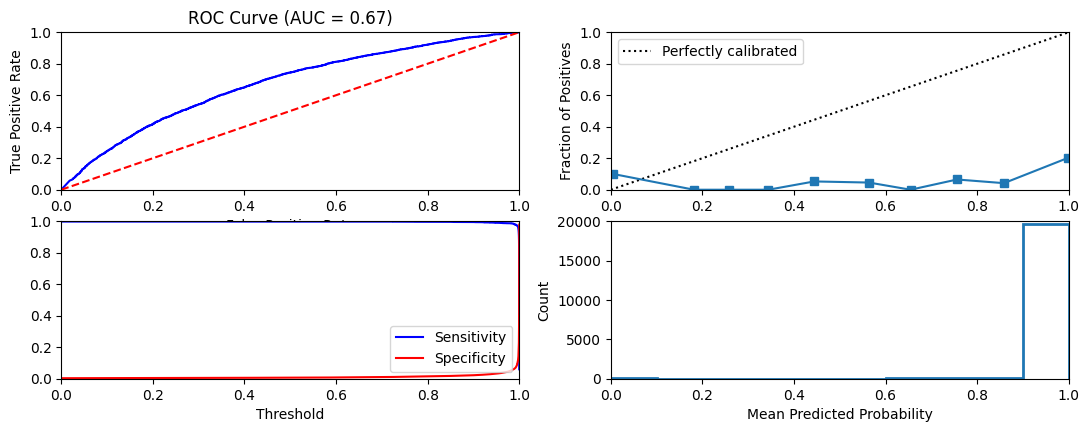


Similarity to LC grade ranking:  0.6609319363332421
Brier score: 0.788029076245117
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.2283]


In [ ]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name = 'Naive Bayes Classifier')

In [ ]:
## Train and test a naive bayes classifier for 100 random seeds
from sklearn.metrics import recall_score, precision_score
import statistics

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  gnb = GaussianNB()
  output = fit_classification(gnb, data_dict, model_name = 'Naive Bayes Classifier', random_state = i, output_to_file = False, 
                              print_to_screen = False, cv_parameters = {})
  
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: Naive Bayes Classifier")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: Naive Bayes Classifier
Average accuracy 0.79813
Average recall 0.0019541710031624627
Average precision 0.03363855552571136


### $l_1$ regularized logistic regression

  Model: l1 Regularized Logistic Regression
Fit time: 168.82 seconds
Optimal parameters:
{'C': 0.01, 'solver': 'saga'}

Accuracy-maximizing threshold was: 0.4925398298036755
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8015    0.9989    0.8894     16016
     Default     0.5610    0.0058    0.0114      3984

    accuracy                         0.8011     20000
   macro avg     0.6813    0.5023    0.4504     20000
weighted avg     0.7536    0.8011    0.7145     20000



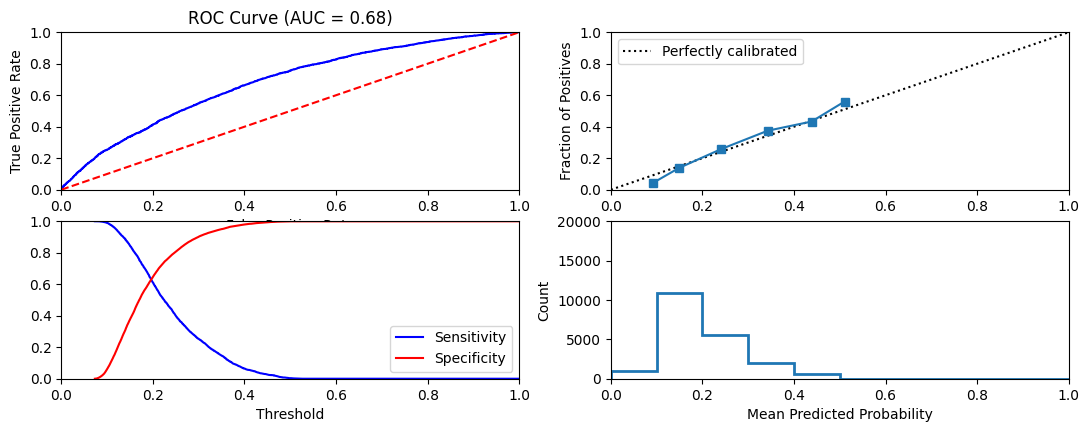


Similarity to LC grade ranking:  0.7489319572281672
Brier score: 0.14962995891145667
Were parameters on edge? : True
Score variations around CV search grid : 0.10001250156271208
[0.79976667 0.79976667 0.79976667 0.79976667 0.79976667 0.79976667
 0.79976667 0.7999     0.79973333 0.7996     0.7991     0.79923333
 0.79936667 0.7994     0.79933333 0.79936667 0.79936667 0.79936667
 0.79936667 0.79936667]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {
    "C": 10.** np.arange(-5, 5),
    'solver': ['liblinear', 'saga']
    }

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, "l1 Regularized Logistic Regression")

In [ ]:
# Train and test a l_1 regularized logistic regression classifier for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  
  l1_logistic = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga')

  output = fit_classification(l1_logistic, data_dict, cv_parameters = {}, model_name = 'l1 Regularized Logistic Regression', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: l1 Regularized Logistic Regression")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: l1 Regularized Logistic Regression
Average accuracy 0.7983500000000003
Average recall 0.030927081050050275
Average precision 0.5086158759243848


### $l_2$ regularized logistic regression

  Model: l2 Regularized Logistic Regression
Fit time: 257.82 seconds
Optimal parameters:
{'C': 0.01, 'solver': 'saga'}

Accuracy-maximizing threshold was: 0.49470868578777316
Accuracy:  0.79375
              precision    recall  f1-score   support

  No default     0.7948    0.9974    0.8846     15858
     Default     0.5842    0.0142    0.0278      4142

    accuracy                         0.7937     20000
   macro avg     0.6895    0.5058    0.4562     20000
weighted avg     0.7512    0.7937    0.7072     20000



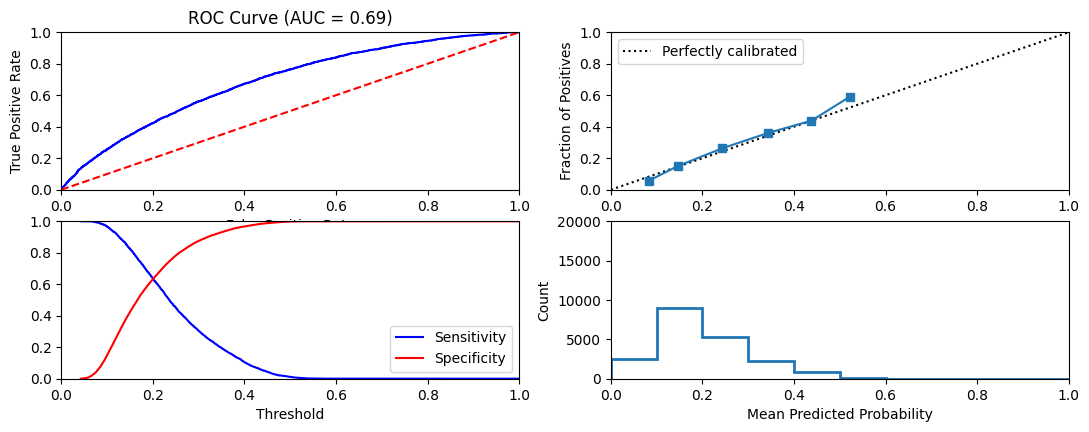


Similarity to LC grade ranking:  0.717219076926079
Brier score: 0.15265745269193975
Were parameters on edge? : True
Score variations around CV search grid : 0.16304347826089335
[0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.7973     0.7971     0.7973     0.7973     0.7973     0.79733333
 0.79603333 0.7961     0.79603333 0.79603333 0.79603333 0.79603333
 0.7968     0.79653333 0.79686667 0.79686667 0.79686667 0.79686667
 0.79666667 0.79663333 0.79656667 0.79656667 0.79656667 0.79656667
 0.79683333 0.7963     0.7963     0.7963     0.79626667 0.79626667
 0.7966     0.7963     0.79626667 0.79626667 0.79626667 0.79626667
 0.79646667 0.79626667 0.79626667 0.79626667 0.79626667 0.79626667]


In [ ]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression()
cv_parameters = {
    "C": 10.** np.arange(-5, 5),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    }

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, "l2 Regularized Logistic Regression")

In [ ]:
# Train and test a l_2 regularized logistic regression classifier for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  
  l2_logistic = LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga')

  output = fit_classification(l2_logistic, data_dict, cv_parameters = {}, model_name = 'l2 Regularized Logistic Regression', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: l2 Regularized Logistic Regression")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: l2 Regularized Logistic Regression
Average accuracy 0.7980865000000003
Average recall 0.0257663688040034
Average precision 0.5039268670291619


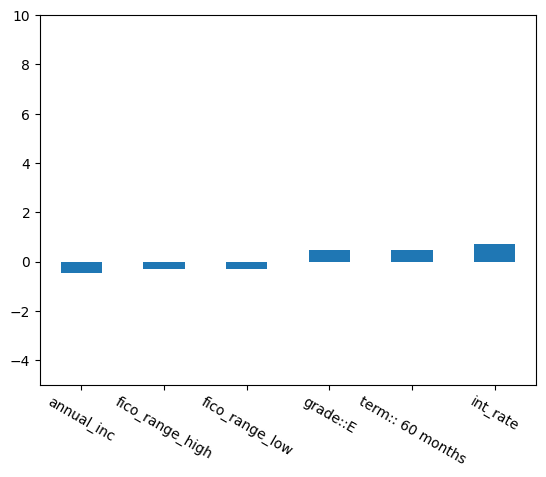

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(output['model'].coef_)[0,:3]) + list(np.argsort(output['model'].coef_)[0,-3:])
bplot = pd.Series(output['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree Classifier
Fit time: 18.92 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 1}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7929
              precision    recall  f1-score   support

  No default     0.7929    1.0000    0.8845     15858
     Default     0.0000    0.0000    0.0000      4142

    accuracy                         0.7929     20000
   macro avg     0.3965    0.5000    0.4422     20000
weighted avg     0.6287    0.7929    0.7013     20000



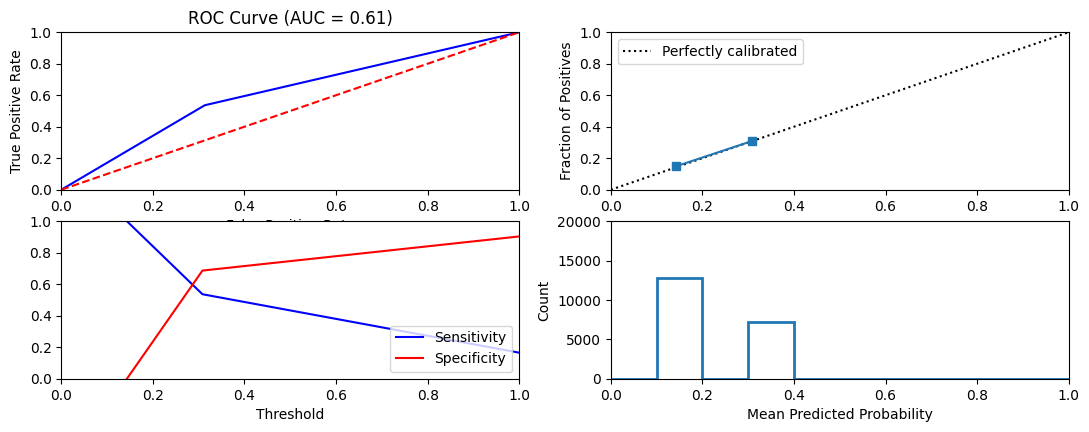


Similarity to LC grade ranking:  0.7092769179096758
Brier score: 0.1584116765970244
Were parameters on edge? : True
Score variations around CV search grid : 3.535712791330182
[0.79663333 0.79663333 0.79663333 0.78936667 0.78893333 0.7859
 0.7853     0.7792     0.77583333 0.76846667 0.79663333 0.79663333
 0.79663333 0.79543333 0.79176667 0.78426667 0.78336667 0.7808
 0.77526667 0.76866667]


In [ ]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {
    'max_depth':np.arange(1, 11), 
    'criterion': ['gini', 'entropy']
}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision Tree Classifier')

In [ ]:
# Train and test a decision tree for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  
  decision_tree = DecisionTreeClassifier(max_depth = 1, criterion = 'gini')

  output = fit_classification(decision_tree, data_dict, cv_parameters = {}, model_name = 'Decision Tree Classifier', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: Decision Tree Classifier")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: Decision Tree Classifier
Average accuracy 0.7981555
Average recall 0.0
Average precision 0.0


### Random forest

  Model: Random Forest Classifier
Fit time: 313.61 seconds
Optimal parameters:
{'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.3251782722733206
Accuracy:  0.76475
              precision    recall  f1-score   support

  No default     0.8274    0.8886    0.8569     15858
     Default     0.4052    0.2904    0.3383      4142

    accuracy                         0.7648     20000
   macro avg     0.6163    0.5895    0.5976     20000
weighted avg     0.7400    0.7648    0.7495     20000



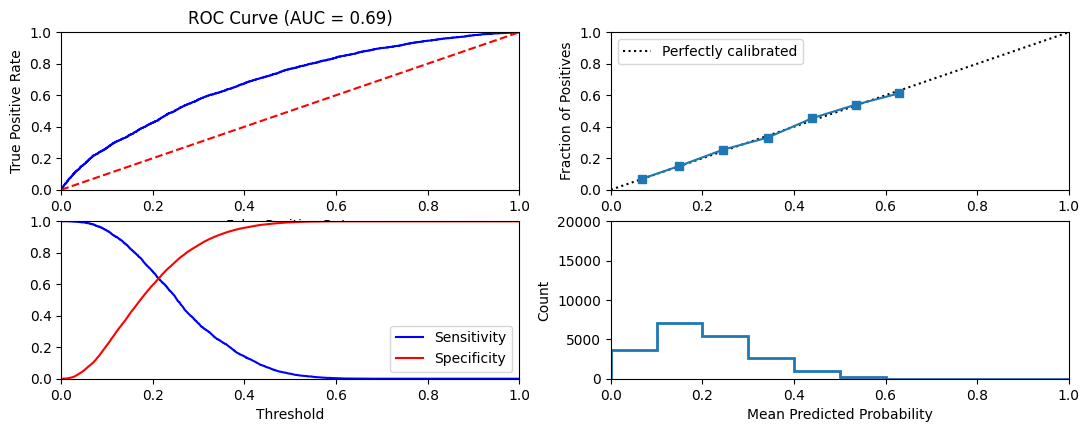


Similarity to LC grade ranking:  0.5795819010954607
Brier score: 0.15168501916848653
Were parameters on edge? : True
Score variations around CV search grid : 0.19637336007354178
[0.79623333 0.7976     0.79733333 0.79756667 0.7966     0.7968
 0.7978     0.7972    ]


In [ ]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {
    'max_depth': [80, 100],
    'min_samples_leaf': [3, 5],
    'n_estimators': [100, 200]
}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random Forest Classifier')

In [ ]:
# Train and test a decision tree for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  
  random_forest = RandomForestClassifier(max_depth = 100, min_samples_leaf = 5, n_estimators = 100)

  output = fit_classification(random_forest, data_dict, cv_parameters = {}, model_name = 'Random Forest Classifier', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: Random Forest Classifier")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: Random Forest Classifier
Average accuracy 0.764427
Average recall 0.3014635253513966
Average precision 0.39168664930446456


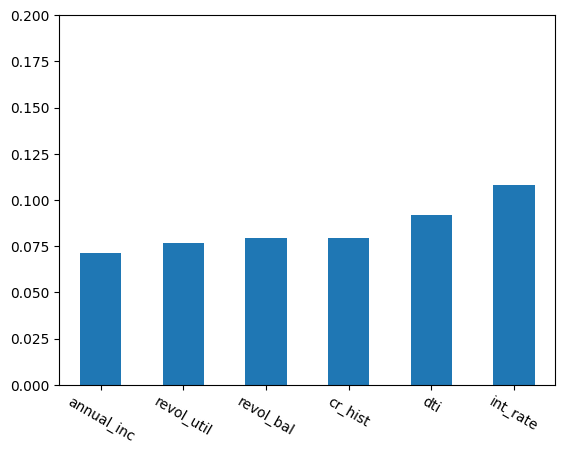

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(output['model'].feature_importances_)[-6:]) 
bplot = pd.Series(output['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-Layer Perceptron
Fit time: 439.46 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 100}

Accuracy-maximizing threshold was: 0.4829997284299434
Accuracy:  0.7936
              precision    recall  f1-score   support

  No default     0.7985    0.9894    0.8837     15858
     Default     0.5200    0.0439    0.0810      4142

    accuracy                         0.7936     20000
   macro avg     0.6592    0.5167    0.4824     20000
weighted avg     0.7408    0.7936    0.7175     20000



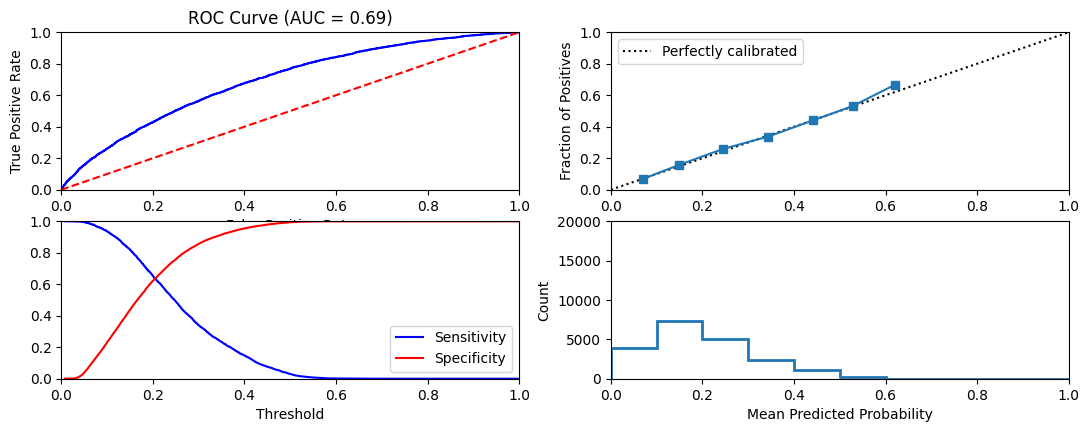


Similarity to LC grade ranking:  0.7344694453649221
Brier score: 0.151926643157687
Were parameters on edge? : True
Score variations around CV search grid : 2.5674317306081385
[0.79586667 0.79576667 0.78616667 0.77543333]


In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 200]
}

mlp = fit_classification(mlp, data_dict,cv_parameters, 'Multi-Layer Perceptron')

In [ ]:
# Train and test a decision tree for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  
  mlp = MLPClassifier(activation = 'logistic', max_iter = 100)

  output = fit_classification(mlp, data_dict, cv_parameters = {}, model_name = 'Multi-Layer Perceptron', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

  # to keep a track of progress
  print(i, end = '')

print("=========================================================")
print("  Model: Multi-Layer Perceptron")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899=========================================================
  Model: Multi-Layer Perceptron
Average accuracy 0.7985649999999995
Average recall 0.0379051631765763
Average precision 0.5197725933538492


In [ ]:
import statistics
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

Average accuracy 0.7985649999999995 +- 0.0029234725788335933
Average recall 0.0379051631765763 +- 0.015124403479671264
Average precision 0.5197725933538492 +- 0.03507390240376758


In [ ]:
### HY: for cv params, i just picked some myself (no recitation for reference yet)

## Train and Test logistic regression model with features derived by LendingClub

  Model: l1 Regularized Logistic Regression for specific feature
Fit time: 3.05 seconds
Optimal parameters:
{'C': 1e-05, 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7929
              precision    recall  f1-score   support

  No default     0.7929    1.0000    0.8845     15858
     Default     0.0000    0.0000    0.0000      4142

    accuracy                         0.7929     20000
   macro avg     0.3965    0.5000    0.4422     20000
weighted avg     0.6287    0.7929    0.7013     20000



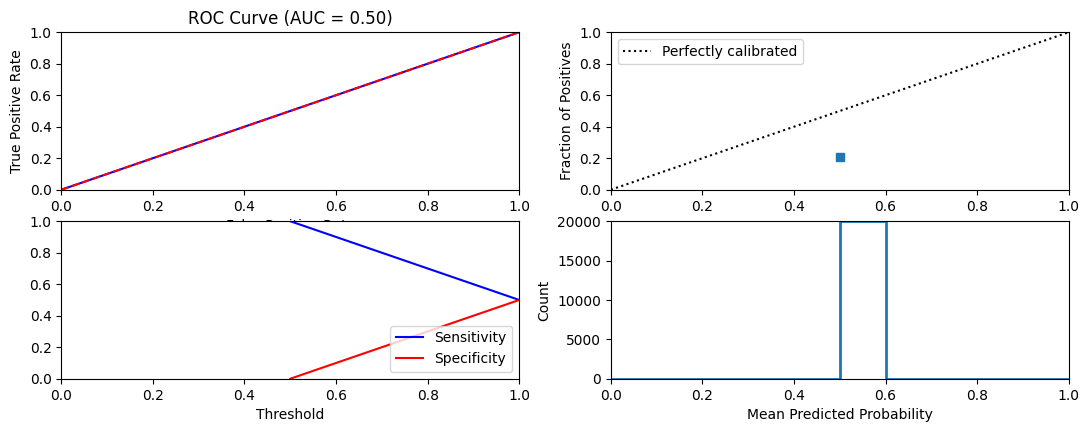


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : True
Score variations around CV search grid : 0.1631867442152351
[0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.7955     0.79546667
 0.79536667 0.79536667 0.79536667 0.79536667 0.79536667 0.79533333
 0.79536667 0.79533333]


In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'dti'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty = 'l1')

# HY: using the same CV params as above
cv_parameters = {
    "C": 10.** np.arange(-5, 5),
    'solver': ['liblinear', 'saga']
    }

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters, "l1 Regularized Logistic Regression for specific feature")

  Model: l2 Regularized Logistic Regression for specific feature
Fit time: 10.06 seconds
Optimal parameters:
{'C': 1e-05, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7929
              precision    recall  f1-score   support

  No default     0.7929    1.0000    0.8845     15858
     Default     0.0000    0.0000    0.0000      4142

    accuracy                         0.7929     20000
   macro avg     0.3965    0.5000    0.4422     20000
weighted avg     0.6287    0.7929    0.7013     20000



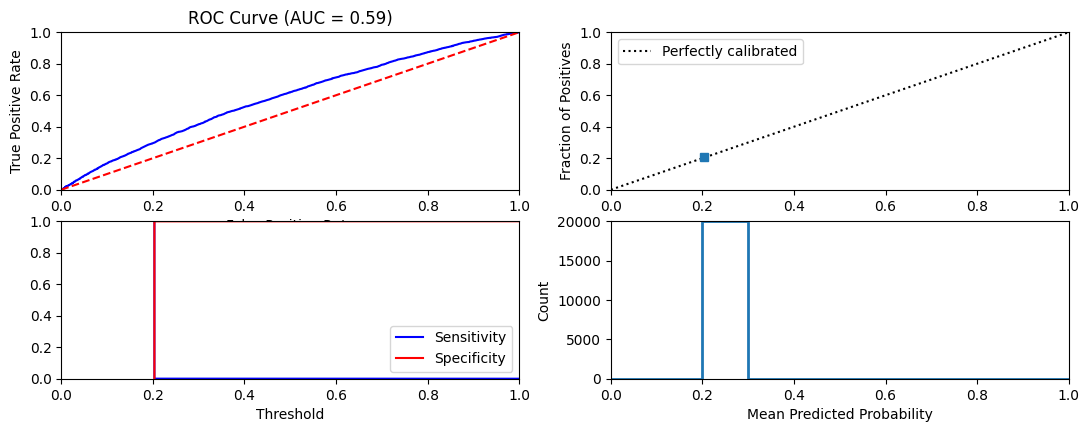


Similarity to LC grade ranking:  0.12730110673944642
Brier score: 0.16422351426603965
Were parameters on edge? : True
Score variations around CV search grid : 0.1631867442152351
[0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333 0.79663333
 0.79636667 0.79636667 0.79636667 0.79636667 0.79636667 0.79636667
 0.7957     0.7957     0.7957     0.7957     0.79576667 0.7957
 0.79536667 0.79536667 0.79536667 0.79536667 0.79536667 0.79536667
 0.79533333 0.79533333 0.79533333 0.79533333 0.79533333 0.79533333
 0.79533333 0.79533333 0.79533333 0.79533333 0.79533333 0.79533333]


In [ ]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression()

# HY: using the same CV params as above
cv_parameters = {
    "C": 10.** np.arange(-5, 5),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    }


lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters, "l2 Regularized Logistic Regression for specific feature")

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [ ]:
# lending_club_features = ['dti','verification_status','grade']
# data_dict = prepare_data(feature_subset = lending_club_features)

# Need to exclude features derived by Lending Club. The list containing all features is your_features
lending_club_features = [feature for feature in your_features if feature not in ['dti', 'verification_status', 'grade']]
data_dict = prepare_data(feature_subset=lending_club_features)

  Model: Naive Bayes Classifier
Fit time: 0.09 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.79785
              precision    recall  f1-score   support

  No default     0.7978    1.0000    0.8876     15957
     Default     0.0000    0.0000    0.0000      4043

    accuracy                         0.7978     20000
   macro avg     0.3989    0.5000    0.4438     20000
weighted avg     0.6366    0.7978    0.7081     20000



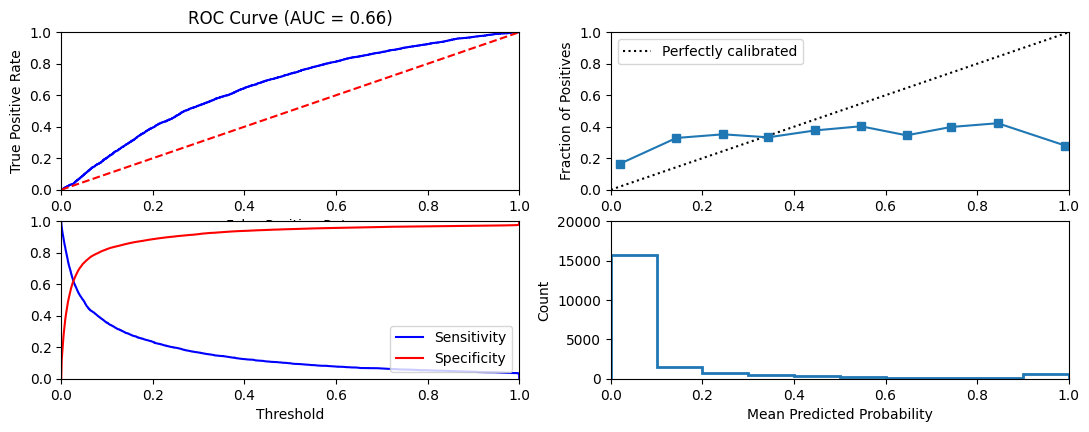


Similarity to LC grade ranking:  0.5141504186374957
Brier score: 0.1927737318690909
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.67346667]
  Model: l1 Regularized Logistic Regression
Fit time: 116.44 seconds
Optimal parameters:
{'C': 0.1, 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.512957012159533
Accuracy:  0.7983
              precision    recall  f1-score   support

  No default     0.8018    0.9925    0.8870     15957
     Default     0.5182    0.0317    0.0597      4043

    accuracy                         0.7983     20000
   macro avg     0.6600    0.5121    0.4734     20000
weighted avg     0.7445    0.7983    0.7198     20000



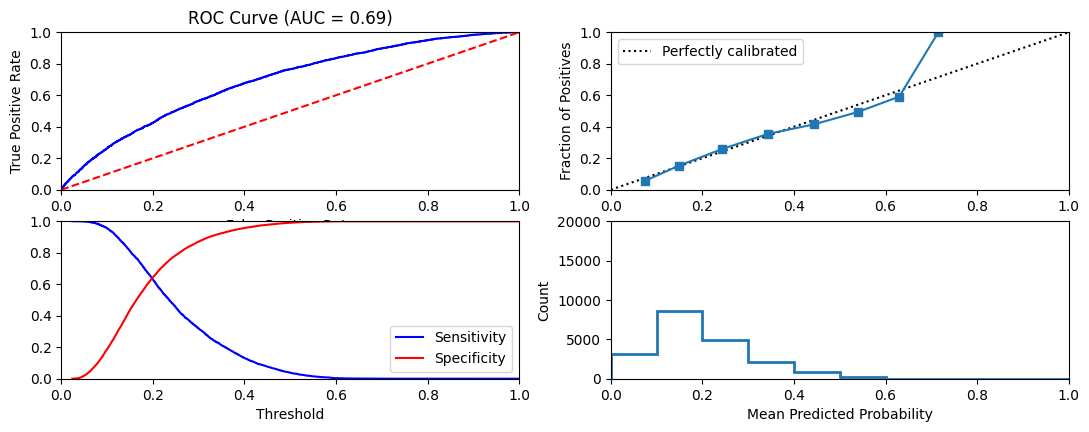


Similarity to LC grade ranking:  0.66348762183624
Brier score: 0.14972491289683687
Were parameters on edge? : True
Score variations around CV search grid : 0.11219147344797795
[0.80196667 0.80196667 0.80196667 0.80196667 0.80196667 0.80196667
 0.80196667 0.80216667 0.8022     0.80186667 0.80143333 0.80143333
 0.80133333 0.80146667 0.80133333 0.8014     0.8013     0.8014
 0.8013     0.8014    ]
  Model: l2 Regularized Logistic Regression
Fit time: 96.59 seconds
Optimal parameters:
{'C': 0.1, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.515356265238333
Accuracy:  0.79765
              precision    recall  f1-score   support

  No default     0.8016    0.9919    0.8866     15957
     Default     0.4921    0.0309    0.0582      4043

    accuracy                         0.7976     20000
   macro avg     0.6469    0.5114    0.4724     20000
weighted avg     0.7390    0.7976    0.7192     20000



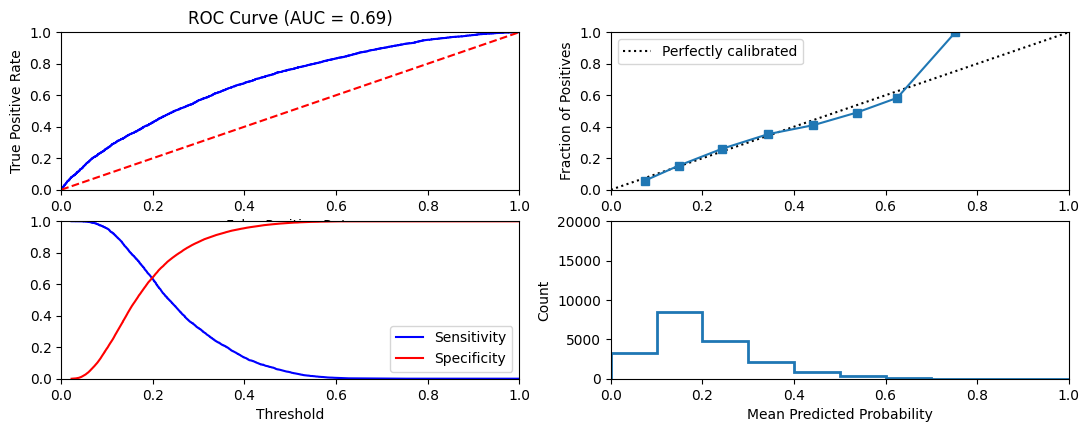


Similarity to LC grade ranking:  0.6542394567970052
Brier score: 0.1496751749767893
Were parameters on edge? : True
Score variations around CV search grid : 0.1329621473386649
[0.80196667 0.80196667 0.80196667 0.80196667 0.80196667 0.80196667
 0.80196667 0.80196667 0.80196667 0.80196667 0.80196667 0.80196667
 0.80196667 0.80196667 0.80196667 0.80196667 0.80196667 0.80196667
 0.80213333 0.80203333 0.80213333 0.80213333 0.80213333 0.80213333
 0.80223333 0.80206667 0.80223333 0.80223333 0.80223333 0.80223333
 0.8014     0.80133333 0.80143333 0.80143333 0.80143333 0.80143333
 0.8014     0.8013     0.80126667 0.80126667 0.80126667 0.80126667
 0.80116667 0.8014     0.80136667 0.80136667 0.80136667 0.8014
 0.80123333 0.80133333 0.80136667 0.80136667 0.80136667 0.8014
 0.8013     0.80133333 0.80136667 0.80136667 0.80136667 0.8014    ]
  Model: Decision Tree Classifier
Fit time: 11.4 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 1}

Accuracy-maximizing threshold was: 1
Accurac

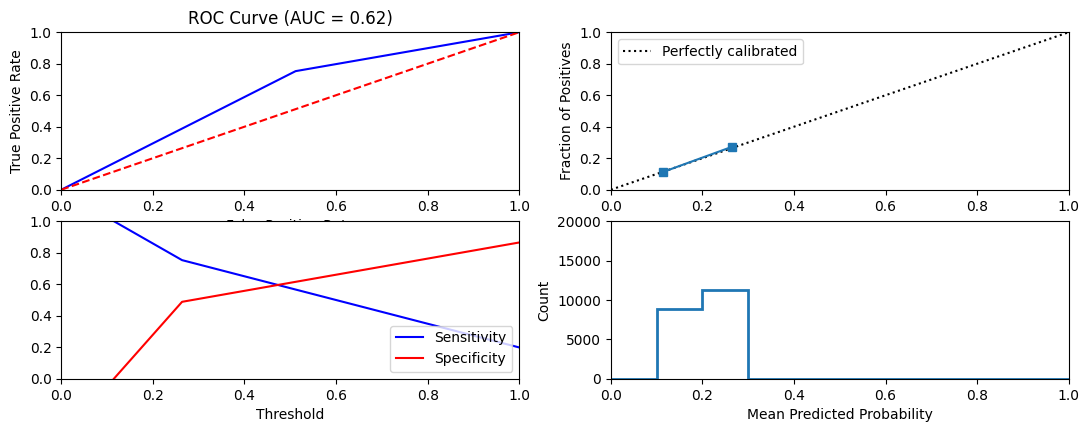


Similarity to LC grade ranking:  0.7501024345765365
Brier score: 0.15517604595769777
Were parameters on edge? : True
Score variations around CV search grid : 3.4249137536888585
[0.80196667 0.80196667 0.80196667 0.7986     0.79396667 0.79216667
 0.78556667 0.7826     0.77933333 0.7745     0.80196667 0.80196667
 0.80196667 0.7963     0.7955     0.79443333 0.78926667 0.78966667
 0.78456667 0.78103333]
  Model: Random Forest Classifier
Fit time: 207.71 seconds
Optimal parameters:
{'max_depth': 80, 'min_samples_leaf': 5, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.3091855166235005
Accuracy:  0.761
              precision    recall  f1-score   support

  No default     0.8327    0.8765    0.8541     15957
     Default     0.3850    0.3050    0.3403      4043

    accuracy                         0.7610     20000
   macro avg     0.6088    0.5908    0.5972     20000
weighted avg     0.7422    0.7610    0.7502     20000



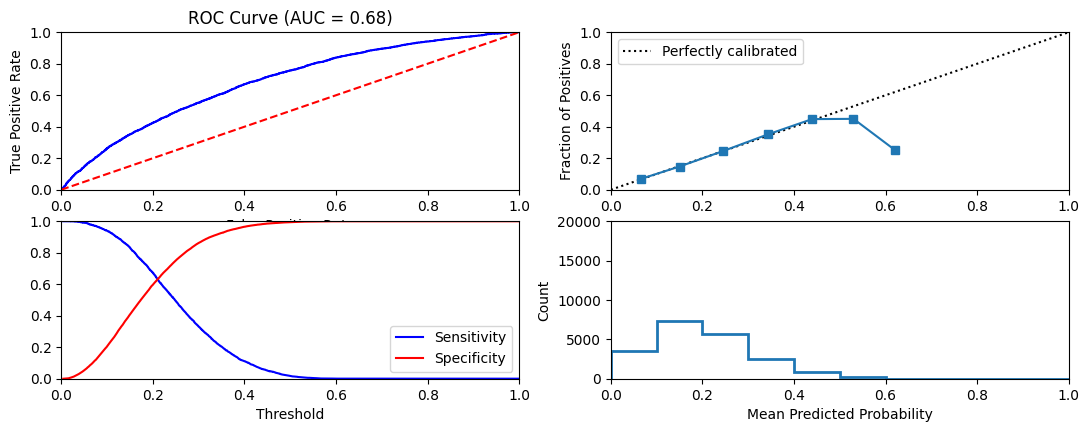


Similarity to LC grade ranking:  0.545562020900715
Brier score: 0.15031966815084194
Were parameters on edge? : True
Score variations around CV search grid : 0.1495016611295793
[0.80153333 0.80223333 0.80266667 0.80256667 0.80173333 0.80193333
 0.80146667 0.80216667]
  Model: Multi-Layer Perceptron
Fit time: 230.49 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 100}

Accuracy-maximizing threshold was: 0.4916799092084872
Accuracy:  0.79775
              precision    recall  f1-score   support

  No default     0.8018    0.9917    0.8867     15957
     Default     0.4962    0.0324    0.0608      4043

    accuracy                         0.7977     20000
   macro avg     0.6490    0.5120    0.4738     20000
weighted avg     0.7400    0.7977    0.7197     20000



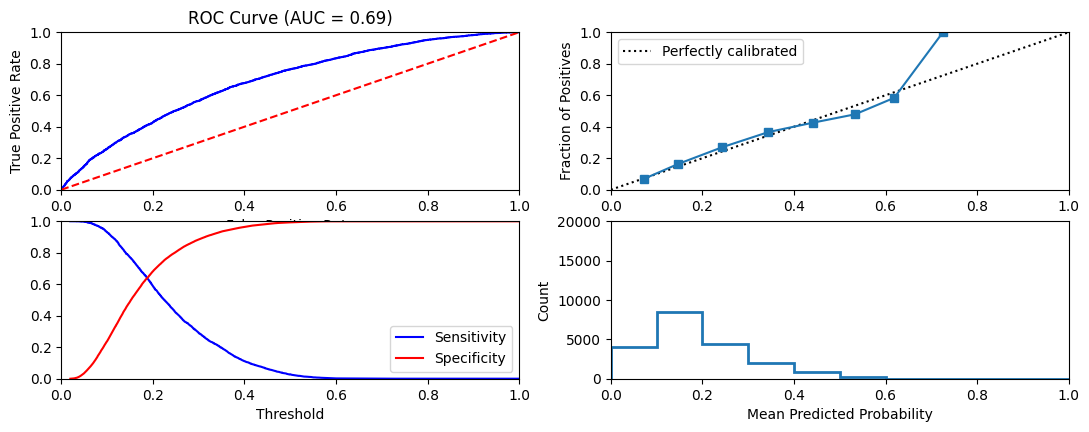


Similarity to LC grade ranking:  0.6564753208332015
Brier score: 0.14981795913373763
Were parameters on edge? : True
Score variations around CV search grid : 1.0309278350515436
[0.80186667 0.80103333 0.79696667 0.7936    ]


In [ ]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name = 'Naive Bayes Classifier')

## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {
    "C": 10.** np.arange(-5, 5),
    'solver': ['liblinear', 'saga']
    }

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, "l1 Regularized Logistic Regression")

## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression()
cv_parameters = {
    "C": 10.** np.arange(-5, 5),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    }

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, "l2 Regularized Logistic Regression")

## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {
    'max_depth':np.arange(1, 11), 
    'criterion': ['gini', 'entropy']
}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision Tree Classifier')

## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {
    'max_depth': [80, 100],
    'min_samples_leaf': [3, 5],
    'n_estimators': [100, 200]
}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random Forest Classifier')

## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 200]
}

mlp = fit_classification(mlp, data_dict,cv_parameters, 'Multi-Layer Perceptron')

In [ ]:
## Train and test a naive bayes classifier for 100 random seeds

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = lending_club_features, random_state=i)
  gnb = GaussianNB()
  output = fit_classification(gnb, data_dict, model_name = 'Naive Bayes Classifier', random_state = i, output_to_file = False, 
                              print_to_screen = False, cv_parameters = {})
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: Naive Bayes Classifier")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: Naive Bayes Classifier
Average accuracy 0.7981185 +- 0.0027935048674459896
Average recall 0.00024329285150617993 +- 0.0007787536477686643
Average precision 0.049961373309013526 +- 0.13461043604212258


In [ ]:
# Train and test a l_1 regularized logistic regression classifier for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = lending_club_features, random_state=i)
  
  l1_logistic = LogisticRegression(penalty = 'l1', C = 0.1, solver = 'liblinear')

  output = fit_classification(l1_logistic, data_dict, cv_parameters = {}, model_name = 'l1 Regularized Logistic Regression', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

print("=========================================================")
print("  Model: l1 Regularized Logistic Regression")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

  Model: l1 Regularized Logistic Regression
Average accuracy 0.7982925000000001 +- 0.0029006127443919963
Average recall 0.021134601882836505 +- 0.012861917415553413
Average precision 0.5041548831502651 +- 0.1232932597336971


In [ ]:

# Train and test a l_2 regularized logistic regression classifier for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = lending_club_features, random_state=i)
  
  l2_logistic = LogisticRegression(penalty = 'l2', C = 0.1, solver = 'lbfgs')

  output = fit_classification(l2_logistic, data_dict, cv_parameters = {}, model_name = 'l2 Regularized Logistic Regression', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)
  # to keep a track of progress
  print(i, end = '')

print("=========================================================")
print("  Model: l2 Regularized Logistic Regression")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899=========================================================
  Model: l2 Regularized Logistic Regression
Average accuracy 0.7982035 +- 0.0029172186057852046
Average recall 0.023429477854630378 +- 0.012790907885106085
Average precision 0.495617332786951 +- 0.09897152777446203


In [ ]:
# Train and test a decision tree for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = lending_club_features, random_state=i)
  
  decision_tree = DecisionTreeClassifier(max_depth = 1, criterion = 'gini')

  output = fit_classification(decision_tree, data_dict, cv_parameters = {}, model_name = 'Decision Tree Classifier', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)
  # to keep a track of progress
  print(i, end = '')

print("=========================================================")
print("  Model: Decision Tree Classifier")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899=========================================================
  Model: Decision Tree Classifier
Average accuracy 0.7981555 +- 0.002817432162430712
Average recall 0.0 +- 0.0
Average precision 0.0 +- 0.0


In [ ]:
# Train and test a Random Forest for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = lending_club_features, random_state=i)
  
  random_forest = RandomForestClassifier(max_depth = 80, min_samples_leaf = 5, n_estimators = 100)

  output = fit_classification(random_forest, data_dict, cv_parameters = {}, model_name = 'Random Forest Classifier', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)
  # to keep a track of progress
  print(i, end = '')

print("=========================================================")
print("  Model: Random Forest Classifier")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899=========================================================
  Model: Random Forest Classifier
Average accuracy 0.7631704999999998 +- 0.004332482987662369
Average recall 0.29338613501058736 +- 0.015363636870392034
Average precision 0.3862545712984059 +- 0.009588726684458811


In [ ]:
# Train and test a Multi-Layer Perceptron for 100 random seeds. Picking optimal cv_param from the run above

accuracies = []
recalls = []
precisions = []

for i in range(100):
  data_dict = prepare_data(feature_subset = lending_club_features, random_state=i)
  
  mlp = MLPClassifier(activation = 'logistic', max_iter = 100)

  output = fit_classification(mlp, data_dict, cv_parameters = {}, model_name = 'Multi-Layer Perceptron', random_state = i, output_to_file = False, 
                              print_to_screen = False)
  accuracy = accuracy_score(data_dict['y_test'], output['y_pred_labels'])
  recall = recall_score(data_dict['y_test'], output['y_pred_labels'])
  precision = precision_score(data_dict['y_test'], output['y_pred_labels'])
  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

  # to keep a track of progress
  print(i, end = '')

print("=========================================================")
print("  Model: Multi-Layer Perceptron")
print("=========================================================")
print('Average accuracy', sum(accuracies)/len(accuracies), '+-', statistics.stdev(accuracies))
print('Average recall', sum(recalls)/len(recalls), '+-', statistics.stdev(recalls))
print('Average precision', sum(precisions)/len(precisions), '+-', statistics.stdev(precisions))

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899=========================================================
  Model: Multi-Layer Perceptron
Average accuracy 0.798283 +- 0.002891080151854052
Average recall 0.021572212461104315 +- 0.012061791216281585
Average precision 0.5068246114087595 +- 0.08677240328301093


## Time stability test of YOURMODEL

  Model: Multi-Layer Perceptron
Fit time: 101.92 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 100}

Accuracy-maximizing threshold was: 0.601902009381255
Accuracy:  0.7862857142857143
              precision    recall  f1-score   support

  No default     0.7863    1.0000    0.8804      5504
     Default     0.0000    0.0000    0.0000      1496

    accuracy                         0.7863      7000
   macro avg     0.3931    0.5000    0.4402      7000
weighted avg     0.6182    0.7863    0.6922      7000



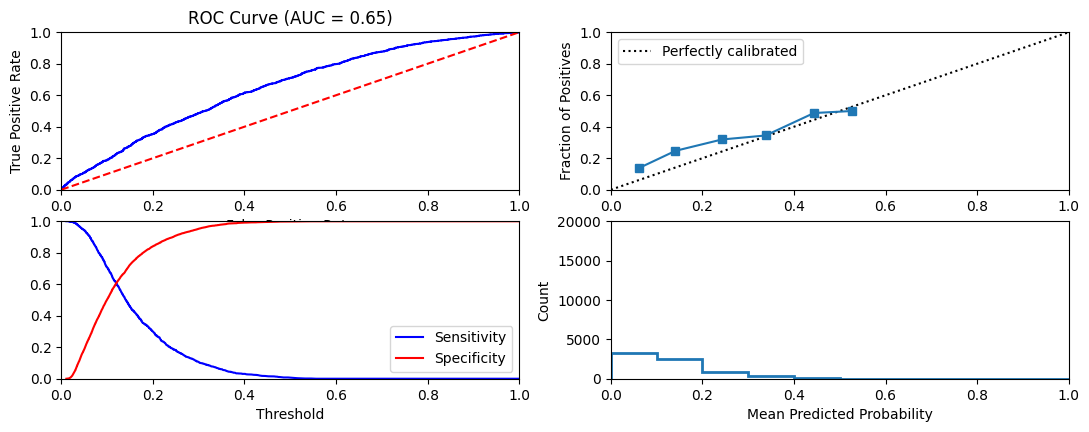


Similarity to LC grade ranking:  0.5688045047187422
Brier score: 0.16824530717900235
Were parameters on edge? : True
Score variations around CV search grid : 3.0584936918567673
[0.87188889 0.87177778 0.86       0.84522222]


In [ ]:
## Train on 2010, Test on 2018
## Define the time window of your train and test data
start_date_train = pd.to_datetime('2010-01-01')
end_date_train = pd.to_datetime('2011-03-01') # selecting this to be the end date since the function returns a negative value if only 1 year considered
start_date_test = pd.to_datetime('2018-01-01')
end_date_test = pd.to_datetime('2018-12-31')

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)


## Train and test a multi-layer perceptron classifier since that performed the best

mlp = MLPClassifier()
cv_parameters = {
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 200]
}

mlp = fit_classification(mlp, data_dict_test,cv_parameters, 'Multi-Layer Perceptron')

  Model: Multi-Layer Perceptron
Fit time: 87.83 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 100}

Accuracy-maximizing threshold was: 0.4964870154012309
Accuracy:  0.7845714285714286
              precision    recall  f1-score   support

  No default     0.7848    0.9996    0.8793      5494
     Default     0.0000    0.0000    0.0000      1506

    accuracy                         0.7846      7000
   macro avg     0.3924    0.4998    0.4396      7000
weighted avg     0.6160    0.7846    0.6901      7000



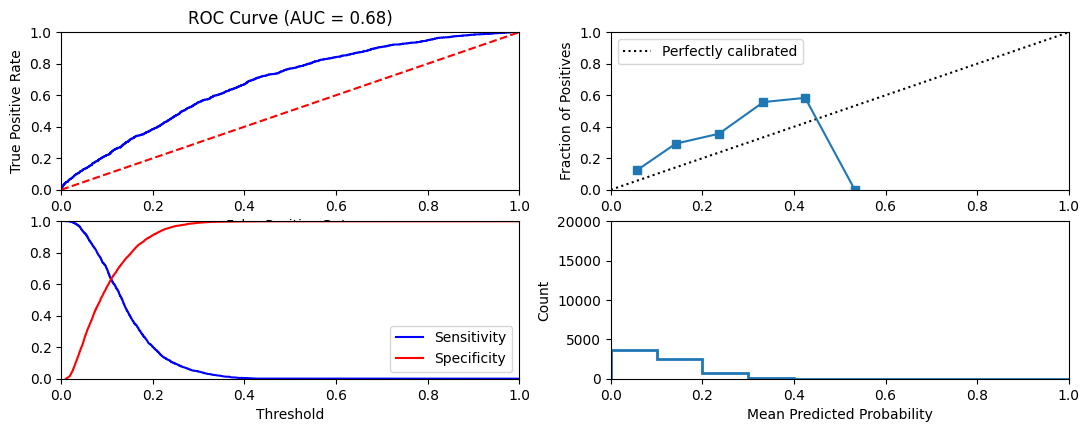


Similarity to LC grade ranking:  0.5393108961547659
Brier score: 0.17018911028195777
Were parameters on edge? : True
Score variations around CV search grid : 1.8101822752985561
[0.88388889 0.88377778 0.878      0.86788889]


In [ ]:
## Train on 2017, Test on 2018
## Define the time window of your train and test data
start_date_train = pd.to_datetime('2017-01-01')
end_date_train = pd.to_datetime('2017-12-31')
start_date_test = pd.to_datetime('2018-01-01')
end_date_test = pd.to_datetime('2018-12-31')

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test a multi-layer perceptron classifier since that performed the best

mlp = MLPClassifier()
cv_parameters = {
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 200]
}

mlp = fit_classification(mlp, data_dict_test,cv_parameters, 'Multi-Layer Perceptron')

## Train and test YOURMODEL on the original data

In [ ]:
import glob
import pandas as pd

In [ ]:
data_path = r'/content/drive/MyDrive/MLPS Case Study/data/unclean data/'


csv_files = glob.glob(data_path+'*.zip')

og_data = pd.DataFrame()

for i,f in enumerate(csv_files):
    og_data = pd.concat([og_data,pd.read_csv(f,skiprows=1,dtype='object')],axis=0)
    

In [ ]:
og_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,disbursement_method
0,164027473,NaN,20000,20000,20000,36 months,12.40%,668.12,B,B4,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,163984413,NaN,16500,16500,16500,60 months,10.33%,353.27,B,B1,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,164193225,NaN,7500,7500,7500,36 months,12.40%,250.55,B,B4,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,162948736,NaN,19000,19000,18975,36 months,6.46%,581.99,A,A1,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,164161686,NaN,10000,10000,10000,36 months,20.55%,374.45,D,D2,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
og_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2777817 entries, 0 to 130634
Columns: 151 entries, id to disbursement_method
dtypes: object(151)
memory usage: 3.1+ GB


  Model: Multi-Layer Perceptron
Fit time: 266.32 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 100}

Accuracy-maximizing threshold was: 0.46335481437837106
Accuracy:  0.79795
              precision    recall  f1-score   support

  No default     0.8034    0.9888    0.8865     15957
     Default     0.5028    0.0448    0.0822      4043

    accuracy                         0.7980     20000
   macro avg     0.6531    0.5168    0.4843     20000
weighted avg     0.7426    0.7980    0.7239     20000



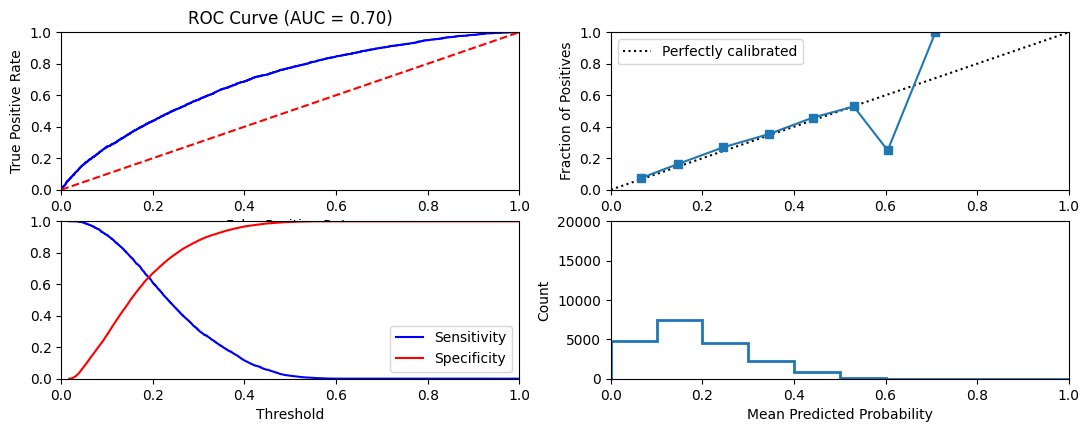


Similarity to LC grade ranking:  0.7160915579299043
Brier score: 0.14895630060570106
Were parameters on edge? : True
Score variations around CV search grid : 2.4811936328498434
[0.80203333 0.80166667 0.79096667 0.78213333]


In [ ]:
your_features = set(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
'zip_code', 'addr_state', 'dti', 'total_pymnt', 'delinq_2yrs', 'earliest_cr_line',
'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 'fico_range_high','fico_range_low',
'application_type', 'revol_bal', 'revol_util', 'recoveries'])

cols_we_have = set(data.columns)

your_features = list(your_features.intersection(cols_we_have))

data_dict = prepare_data(feature_subset = your_features)

## Train and test a multi-layer perceptron classifier since that performed the best

mlp = MLPClassifier()
cv_parameters = {
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 200]
}

mlp = fit_classification(mlp, data_dict,cv_parameters, 'Multi-Layer Perceptron')


## Test regression models

In [ ]:
# get previous data_dict again (so that we dont use the one overwritten by the specific feature from lending club)
## define your set of features to use in different models
your_features = ['grade', 'verification_status', 'emp_length', 'term', 'purpose', 'home_ownership',
                 'loan_amnt', 'funded_amnt', 'funded_amnt', 'annual_inc', 'delinq_2yrs', 'dti',
                 'fico_range_high', 'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal', 'total_pymnt',
                 'recoveries', 'int_rate', 'revol_util', 'loan_status', 'loan_length', 'term_num'
                 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'cr_hist']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
########### NEED HELP IN IDENTIFYING METRIC FOR PERFORMANCE - NIMA ##############
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        # y_train = data.loc[filter_train, ret_col].as_matrix()
        # y_test = data.loc[filter_test, ret_col].as_matrix() 
        y_train = data.loc[filter_train, ret_col].fillna(0).to_numpy()
        y_test = data.loc[filter_test, ret_col].fillna(0).to_numpy() 
        

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [ ]:
### HY: I kept getting errors when running this cell, chatgpt says that "y_train = data.loc[filter_train, ret_col].as_matrix()
#         y_test = data.loc[filter_test, ret_col].as_matrix()" is deprecated and i shd use tonumpy instead, so i modified the
# original code a bit, and then since NaN values are in y, when i fit i keep getting value errors, so i fill them with 0 first lol

### $l_1$ regularized linear regression

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters
from sklearn.linear_model import Lasso
cv_parameters = {'alpha': [0.01, 0.1, 1]}

reg_lasso = fit_regression(Lasso(), data_dict, cv_parameters, model_name = "l1 Regularized Linear Regressor")

  Model: l1 Regularized Linear Regressor  Return column: ret_PESS
Fit time: 0.28 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -0.00023754009179333124
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.17099327 -0.17099327 -0.17099327]
  Model: l1 Regularized Linear Regressor  Return column: ret_OPT
Fit time: 0.26 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -0.00015705105253704943
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.0308418 -0.0308418 -0.0308418]
  Model: l1 Regularized Linear Regressor  Return column: ret_INTa
Fit time: 0.38 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.0031082386174524634
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -32.47516969952889
All test scores : [-0.0115442 -0.0152932 -0.0152932]
  Model: l1 Regularized Linear Regressor  Re

In [ ]:
### HY: same cv params as recitation

### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters
from sklearn.linear_model import Ridge
cv_parameters = {'alpha': [0.01, 0.1, 1]}

reg_ridge = fit_regression(Ridge(), data_dict, cv_parameters, model_name = "l2 Regularized Linear Regressor")

  Model: l2 Regularized Linear Regressor  Return column: ret_PESS
Fit time: 0.47 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.03854417508342589
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.6410719443624497
All test scores : [-0.17582155 -0.1751248  -0.17298278]
  Model: l2 Regularized Linear Regressor  Return column: ret_OPT
Fit time: 0.5 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.01973817313455195
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -7.9717228931290105
All test scores : [-0.02624045 -0.0257695  -0.02430308]
  Model: l2 Regularized Linear Regressor  Return column: ret_INTa
Fit time: 0.46 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.04070220894833032
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -35.12361478801223
All test scores : [-0.00760006 -0.00711167 -0.00562452]
  Model: l2 Regularized Line

In [ ]:
### HY: same cv params as recitation

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 200]
}

reg_mlp = fit_regression(MLPRegressor(), data_dict, cv_parameters, model_name = "Multi-Layer Perceptron Regressor")

  Model: Multi-Layer Perceptron Regressor  Return column: ret_PESS
Fit time: 36.33 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 200}

Testing r2 score: -0.02596481427315811
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -22.322413926460904
All test scores : [-0.18505849 -0.16832047 -0.20589366 -0.1808753 ]
  Model: Multi-Layer Perceptron Regressor  Return column: ret_OPT
Fit time: 37.44 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 100}

Testing r2 score: 0.017010235233396953
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -165.38445226752157
All test scores : [-0.03692642 -0.09799697 -0.0904232  -0.05314999]
  Model: Multi-Layer Perceptron Regressor  Return column: ret_INTa
Fit time: 61.72 seconds
Optimal parameters:
{'activation': 'logistic', 'max_iter': 200}

Testing r2 score: 0.037356628437842376
Were parameters on edge (model) : True
Score variations around C

In [ ]:
### HY: cv params same as above for perceptron classifier

### Random forest regressor

In [ ]:
# [AS] The code should be fine but it takes ages to run. Hence I haven't run it either.
## trying random forest regression with hyper-parameters

cv_parameters = {
    'max_depth': [80, 100],
    'min_samples_leaf': [3, 5],
    'n_estimators': [100, 200]
}

reg_rf = fit_regression(RandomForestRegressor(), data_dict, cv_parameters, model_name = "Random Forest Regressor")

KeyboardInterrupt: ignored

In [ ]:
# HY: same cv params as recitation, this one ran too long so i give up first, but the code shd be good
# full set of recitation params as follows:
# cv_parameters = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 100]
# }

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)


            ## Select num_loans to invest in
            pf_test = data_test.loc[:num_loans,:]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.loc[:num_loans,:]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.loc[:num_loans,:]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.loc[:num_loans,:]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [ ]:
## Test investment strategies using the best performing regressor
# TODO: fill in the best performing regressor. assuming it is reg_ridge

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict, classifier = mlp, regressor=reg_ridge, strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: -0.00022974497144927558
ret_OPT: 0.03422247521321321
ret_INTa: 0.4076777467016205
ret_INTb: 1.2489729275540757


In [ ]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict, classifier = mlp, regressor=reg_ridge, strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.013739442133088869
ret_OPT: 0.03704431432307277
ret_INTa: 0.4143227640724814
ret_INTb: 1.2451783957748803


In [ ]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, classifier = mlp, regressor=reg_ridge, strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.018513184782757285
ret_OPT: 0.041373944235819346
ret_INTa: 0.412865607621373
ret_INTb: 1.2563465366883657


In [ ]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'alpha': [0.01, 0.1, 1]} # cv according to best performing model

reg_separate = fit_regression(Ridge(), data_dict, cv_parameters, model_name = "l2 Regularized Linear Regressor", separate = True)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict, classifier = mlp, regressor=reg_separate, strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

  Model: l2 Regularized Linear Regressor  Return column: ret_PESS
Fit time: 0.25 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 1}

Testing r2 scores:
model_0: 0.062186436965548264
model_1: 0.14267626758513674
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -1.15795214753271
All test scores : [-0.67421614 -0.67319042 -0.66649841]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -1.5346350319699937
All test scores : [-0.27719586 -0.27563759 -0.27300621]
  Model: l2 Regularized Linear Regressor  Return column: ret_OPT
Fit time: 0.26 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 1}

Testing r2 scores:
model_0: 0.14510458997626885
model_1: 0.12676202243563317
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 0.5795934643504953
All test scores : [0.31542312 0.31570327 0.31726195]
Were parameters on edge (model_1) : True
S

## Sensitivity test of portfolio size

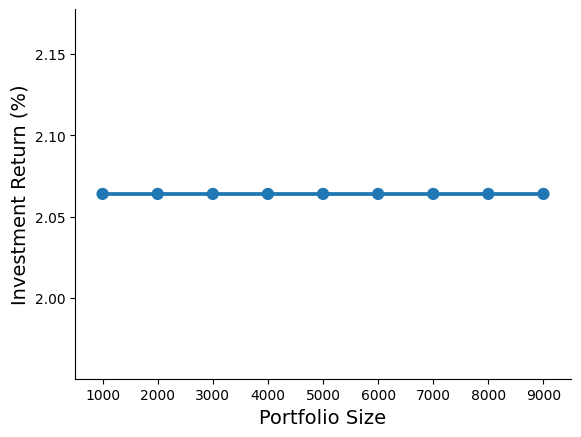

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    # [AS] assuming that the Default return based is the best one, and reg_separate is the best regressor and mlp is the best classifier
    reg_0 = test_investments(data_dict, classifier = mlp, regressor=reg_separate, strategy = 'Default-return-based')
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(x = np.array(list(range(1000,10000,1000))),y = result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()